### Q4 Part 2 <br>
The above only helps us with a qualitative comparison. Let us now do a
quantitative comparison. First, skim read this article: https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Super-Resolution [2 Marks]

*   Start with a 400x400 image (ground truth high resolution).
*   Resize it to a 200x200 image (input image)
*   Use RFF + Linear regression to increase the resolution to 400x400 (predicted high resolution image)
Compute the following metrics:
RMSE on predicted v/s ground truth high resolution image
Peak SNR


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.6 MB/s eta 0:00:00


In [2]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

--2024-03-06 07:03:03--  https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg
Resolving segment-anything.com (segment-anything.com)... 99.84.203.80, 99.84.203.93, 99.84.203.111, ...
Connecting to segment-anything.com (segment-anything.com)|99.84.203.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221810 (217K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 216.61K  --.-KB/s    in 0.02s   

2024-03-06 07:03:03 (11.0 MB/s) - ‘dog.jpg’ saved [221810/221810]



In [3]:
img = torchvision.io.read_image("dog.jpg")
img.shape

torch.Size([3, 1365, 2048])

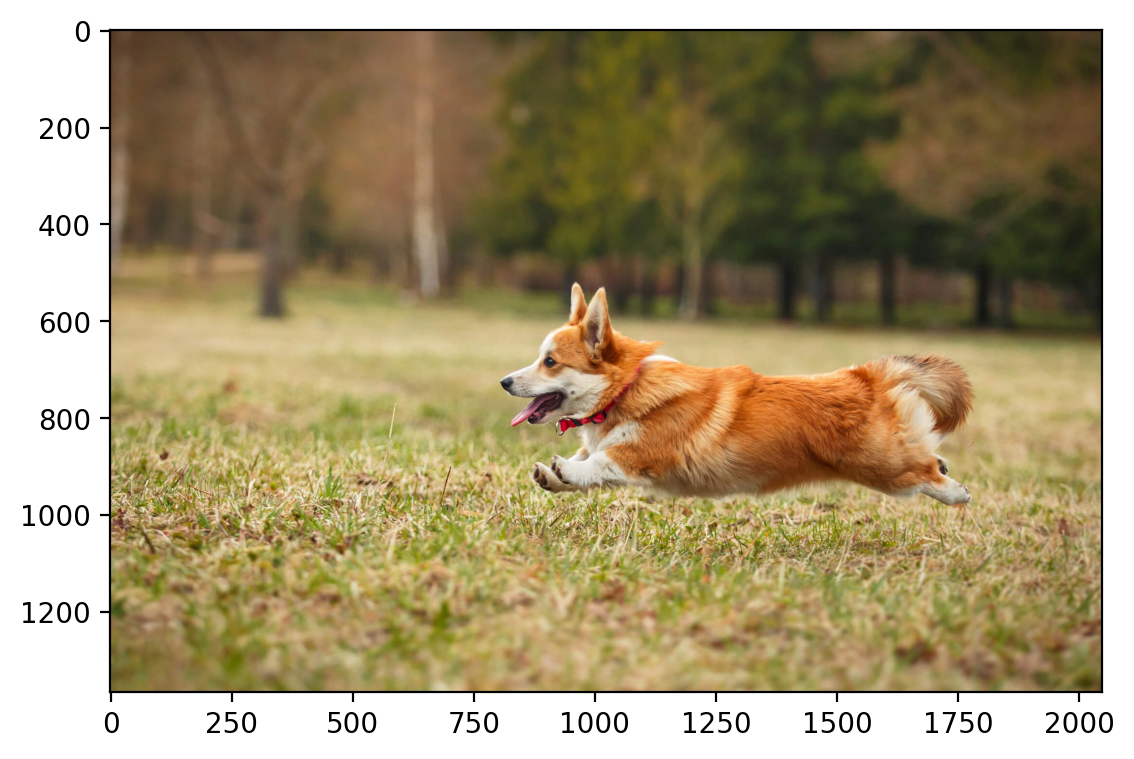

In [4]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [5]:
from sklearn import preprocessing

In [6]:
scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

In [7]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 400, 400)
crop.shape

torch.Size([3, 400, 400])

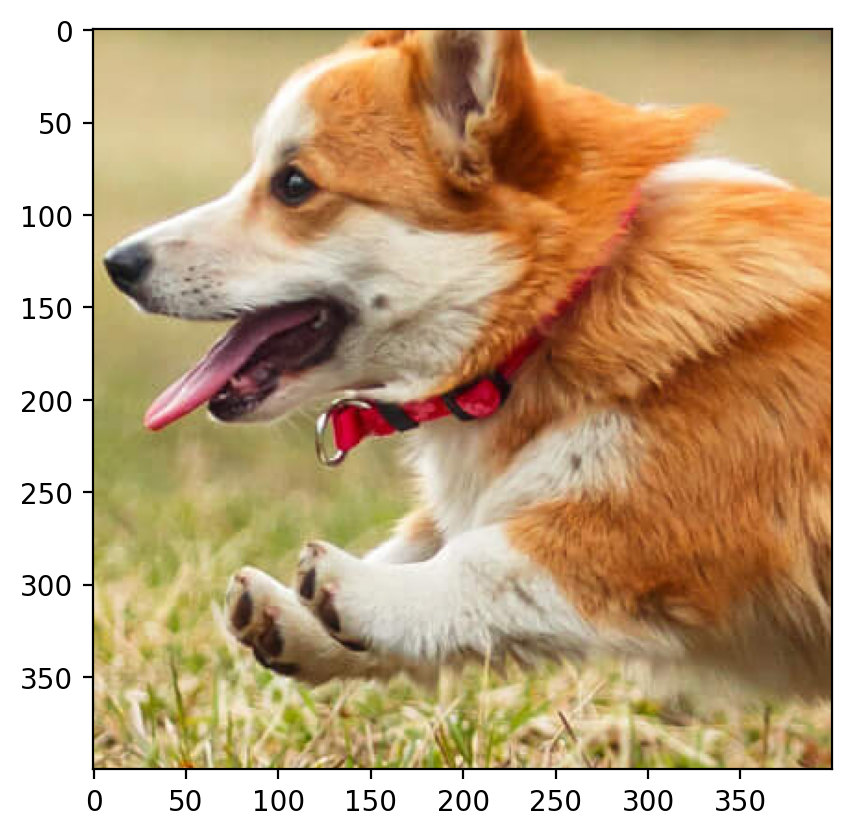

In [8]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [9]:
crop = crop.to(device)

### Resizing the image using OpenCv

In [10]:
import cv2

resized_crop = cv2.resize(rearrange(crop, 'c h w -> h w c').cpu().numpy(), (200, 200))

resized_crop = torch.tensor(resized_crop)

resized_crop = resized_crop.to(device)


In [11]:
resized_crop.shape

torch.Size([200, 200, 3])

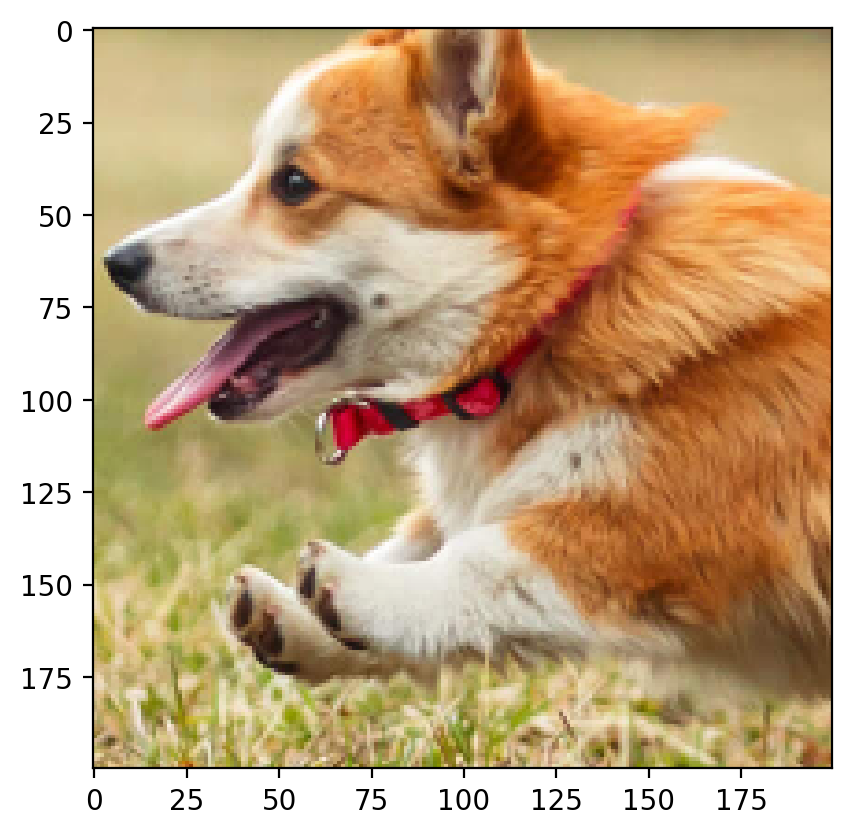

In [12]:
plt.imshow(resized_crop.cpu().numpy())

### Creating (x,y) Coordinates features corresponding to each pixel.

In [13]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (height, width , num_channels)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """
    height, width , num_channels = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'h w c-> (h w) c').float()
    return X, Y

In [14]:
dog_X , dog_Y = create_coordinate_map(resized_crop)
print(dog_X.shape)
print(dog_Y.shape)
print(dog_X.device)
print(dog_Y.device)

torch.Size([40000, 2])
torch.Size([40000, 3])
cuda:0
cuda:0


In [15]:
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

# Scale the X coordinates
dog_X_scaled = scaler_X.transform(dog_X.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

# Set to dtype float32
dog_X_scaled = dog_X_scaled.float()
dog_X_scaled



tensor([[-1.0000, -1.0000],
        [-1.0000, -0.9899],
        [-1.0000, -0.9799],
        ...,
        [ 1.0000,  0.9799],
        [ 1.0000,  0.9899],
        [ 1.0000,  1.0000]], device='cuda:0')

## Now lets create a Linear Model

In [16]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

In [17]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)

        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

## Create RFF features



In [18]:
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2) , random_state=42)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

#### We already have two feature for our X_dog dataset which is made of corrodinates axis , now we are appending more feature to our X_dog dataset using RFFSampler which inheritly uses Random Forier Feature.

In [19]:
X_dog_rff = create_rff_features(dog_X_scaled, 15000, 0.008)

In [20]:
print(X_dog_rff.shape)
print(dog_Y.shape)

torch.Size([40000, 15000])
torch.Size([40000, 3])


In [21]:
model = LinearModel(X_dog_rff.shape[1], dog_Y.shape[1])

model.to(device)

train(model, 0.005, X_dog_rff, dog_Y, 2500)

Epoch 0 loss: 0.366932
Epoch 100 loss: 0.050538
Epoch 200 loss: 0.013619
Epoch 300 loss: 0.008619
Epoch 400 loss: 0.006418
Epoch 500 loss: 0.004987
Epoch 600 loss: 0.003996
Epoch 700 loss: 0.003281
Epoch 800 loss: 0.002750
Epoch 900 loss: 0.002346
Epoch 1000 loss: 0.002031
Epoch 1100 loss: 0.001784
Epoch 1200 loss: 0.001587
Epoch 1300 loss: 0.001428
Epoch 1400 loss: 0.001299
Epoch 1500 loss: 0.001194
Epoch 1600 loss: 0.001106
Epoch 1700 loss: 0.001034
Epoch 1800 loss: 0.000973
Epoch 1900 loss: 0.000922
Epoch 2000 loss: 0.000879
Epoch 2100 loss: 0.000842
Epoch 2200 loss: 0.000810
Epoch 2300 loss: 0.000783
Epoch 2400 loss: 0.000760


0.0007411738042719662

## Now we have learn the Model for 200 x 200 image , Now we will create a feature corrdinates axis for 400 x 400 then rescale it to -1 to 1 then try to find Y of size 400 x 400 x 3.

In [22]:
def create_coordinate_map2(img, scale=1):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    height, width , ch = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(0, width,  1/scale).repeat(int(height*scale), 1)
    h_coords = torch.arange(0, height, 1/scale).repeat(int(width*scale), 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    # Y = rearrange(img, 'c h w -> (h w) c').float()
    return X

In [23]:
resized_crop.shape

torch.Size([200, 200, 3])

In [24]:
dog_X_super  = create_coordinate_map2(resized_crop , scale=2)
dog_X_super

tensor([[  0.0000,   0.0000],
        [  0.0000,   0.5000],
        [  0.0000,   1.0000],
        ...,
        [199.5000, 198.5000],
        [199.5000, 199.0000],
        [199.5000, 199.5000]], device='cuda:0')

In [25]:
super_scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X_super.cpu())

# Scale the X coordinates
dog_X_super_scaled = super_scaler_X.transform(dog_X_super.cpu())

# Move the scaled X coordinates to the GPU
dog_X_super_scaled = torch.tensor(dog_X_super_scaled).to(device)

# Set to dtype float32
dog_X_super_scaled = dog_X_super_scaled.float()
dog_X_super_scaled

tensor([[-1.0000, -1.0000],
        [-1.0000, -0.9950],
        [-1.0000, -0.9900],
        ...,
        [ 1.0000,  0.9900],
        [ 1.0000,  0.9950],
        [ 1.0000,  1.0000]], device='cuda:0')

### Now We will add RFF in our dog_X_super_scaled which would be same as the number of feature that we have used earlier which is 15000 also we are taking the same random state as earlier so our features generated would correspond to previous features

In [26]:
def create_rff_features2(X, num_features, sigma, device):
    from sklearn.kernel_approximation import RBFSampler
    import numpy as np

    X_np = X.cpu().numpy()
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2), random_state=42)
    X_rff = rff.fit_transform(X_np)
    X_tensor = torch.tensor(X_rff, dtype=torch.float32, device=device)

    return X_tensor


In [27]:
dog_X_super_scaled_rff = create_rff_features2(dog_X_super_scaled, 15000, 0.008 ,device)

In [28]:
print(dog_X_super_scaled_rff.device)
print(dog_X_super_scaled.device)
print(dog_X_super.device)
print(dog_X.device)
print(X_dog_rff.device)

cuda:0
cuda:0
cuda:0
cuda:0
cuda:0


In [29]:
# del dog_X_super_scaled_rff
# del dog_X_super_scaled
# del dog_X_super
# del dog_X
# del X_dog_rff

In [30]:
# torch.cuda.empty_cache()

In [31]:
(dog_X_super_scaled_rff.element_size() * dog_X_super_scaled_rff.numel())/(1024 ** 3)

8.940696716308594

In [32]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original 400x400 Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()
    return outputs

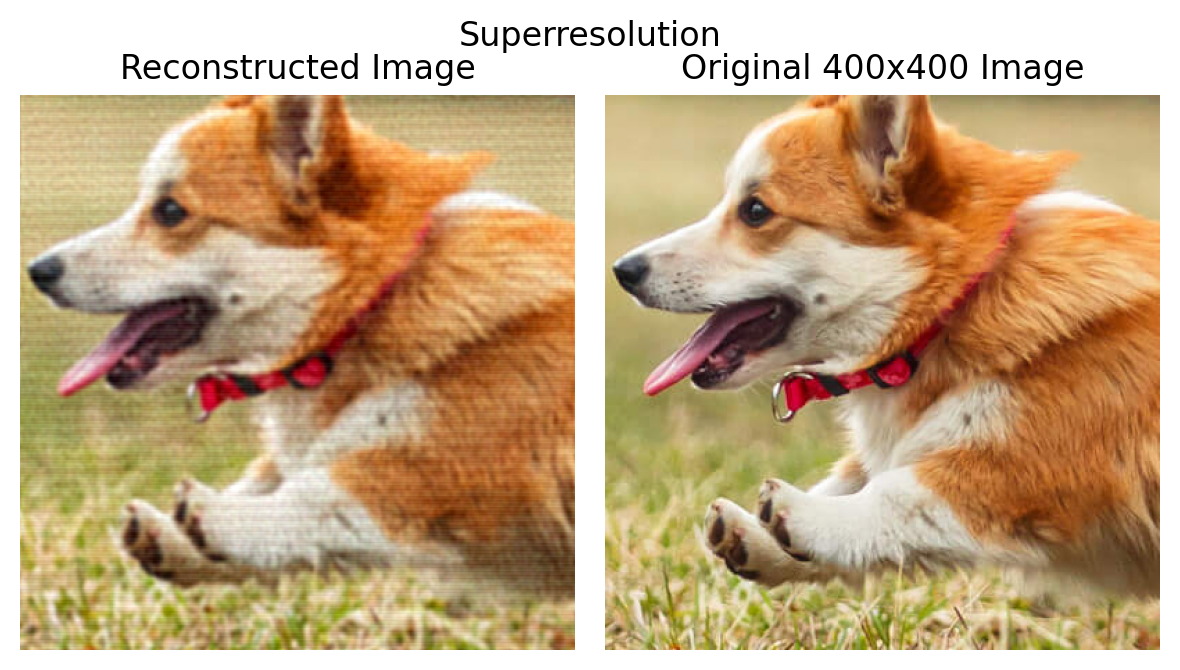

In [33]:
Output_Y = plot_reconstructed_and_original_image(crop, model , dog_X_super_scaled_rff , title="Superresolution")

In [35]:
mse = ((Output_Y.cpu().numpy() - rearrange(crop , 'c h w -> h w c').cpu().numpy())**2).sum() / (crop.shape[0]* crop.shape[1]* crop.shape[2])

rmse = np.sqrt(mse)
rmse

MAX=1.0 # MAX represents the maximum possible pixel value of the image (e.g., 255 for an 8-bit grayscale image or 1 for a normalized image).

PSNR = 10 * np.log10((MAX ** 2) / mse)

print('RMSE:', rmse)
print('Peak SNR:' , PSNR)

RMSE: 0.04189562893523722
Peak SNR: 27.55662571171541
